In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def preprocess_image(image_path, augment=True):

    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img = cv2.resize(img, (96, 96))

        if augment:
            # Convert to tensor for tf.image operations
            img = tf.convert_to_tensor(img)

            img = tf.image.random_brightness(img, 0.2)

            img = tf.image.random_contrast(img, 0.8, 1.2)

            img = tf.image.random_flip_left_right(img)

            # Convert back to numpy
            img = img.numpy()

        # Normalize
        img = img.astype(np.float32) / 255.0

        # Ensure values are in [0,1]
        img = np.clip(img, 0, 1)

        return img

    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None


In [ ]:
def prepare_dataset():
    images = []
    labels = []

    mask_path = '/content/drive/MyDrive/mask_data/with_mask'
    for img_path in os.listdir(mask_path):
        img = preprocess_image(os.path.join(mask_path, img_path))
        if img is not None:
            images.append(img)
            labels.append(1)

    no_mask_path = '/content/drive/MyDrive/mask_data/without_mask'
    for img_path in os.listdir(no_mask_path):
        img = preprocess_image(os.path.join(no_mask_path, img_path))
        if img is not None:
            images.append(img)
            labels.append(0)

    return np.array(images), np.array(labels)

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(96, 96, 3)),

        # First conv block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),

        # Second conv block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),

        # Third conv block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),

        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    return model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val):
    # Calculate class weights
    class_weights = dict(zip(
        np.unique(y_train),
        class_weight.compute_class_weight('balanced',
                                        classes=np.unique(y_train),
                                        y=y_train)
    ))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        X_train, y_train,
        epochs=30,
        validation_data=(X_val, y_val),
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks
    )

    return history

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()

    #Saving The Model
    with open('mask_detection.tflite', 'wb') as f:
        f.write(tflite_model)

In [ ]:
def main():
    # Download and prepare dataset
    print("Preparing dataset...")
    X, y = prepare_dataset()

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Print dataset info
    print(f"\nDataset shapes:")
    print(f"Training: {X_train.shape}")
    print(f"Validation: {X_val.shape}")
    print(f"Testing: {X_test.shape}")

    # Build and train model
    print("\nBuilding and training model...")
    model = build_model()
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Plot training history
    plot_training_history(history)

    # Evaluate on test set
    print("\nEvaluating model...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate classification report
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Mask', 'Mask']))

    # Convert to TFLite
    print("\nConverting to TFLite...")
    convert_to_tflite(model)
    print("Model saved as 'mask_detection.tflite'")

Preparing dataset...

Dataset shapes:
Training: (1280, 96, 96, 3)
Validation: (320, 96, 96, 3)
Testing: (400, 96, 96, 3)

Building and training model...
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7818 - loss: 0.8206 - val_accuracy: 0.4500 - val_loss: 3.0840 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8868 - loss: 0.3321 - val_accuracy: 0.4938 - val_loss: 1.8976 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9365 - loss: 0.1792 - val_accuracy: 0.4656 - val_loss: 1.8815 - learning_rate: 0.0010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9194 - loss: 0.2005 - val_accuracy: 0.4656 - val_loss: 3.1330 - learning_rate: 0.0010
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9411 - loss: 0.1409 - val_accuracy: 0.6156 - val_loss: 1.0363 - learning_rate: 0.0010
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9520 - loss: 0.1308 - val_a

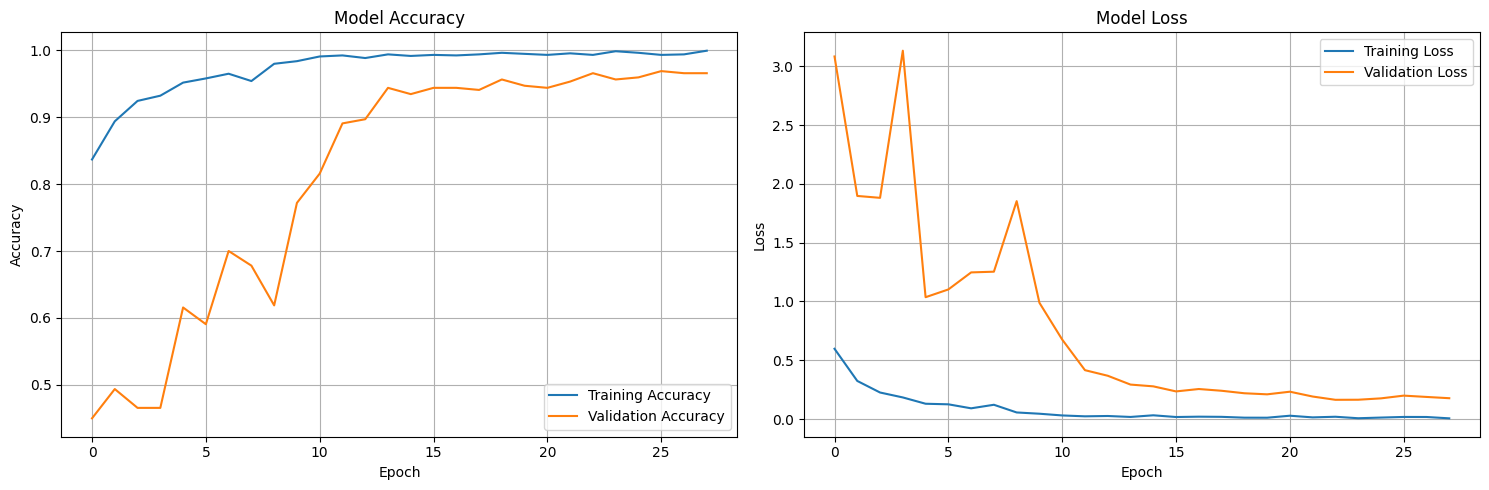


Evaluating model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.9593 - loss: 0.1373
Test accuracy: 0.9650
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.94      1.00      0.97       201
        Mask       0.99      0.93      0.96       199

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400


Converting to TFLite...
Saved artifact at '/tmp/tmphe4psda6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135997364160656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997364162384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997364162576: TensorSpec(shape=(), 

In [ ]:
if __name__ == "__main__":
    main()